In [70]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [71]:
# Load the CO2 concentration data
df = pd.read_csv("C:/Users/mohdz/OneDrive/Desktop/co2_mm_gl.csv")
df = df[['year', 'month', 'average']]
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df = df.set_index(df.date)
df = df[['average']]
df.head()

,average
date,
1979-01-01,336.56
1979-02-01,337.29
1979-03-01,337.88
1979-04-01,338.32
1979-05-01,338.26


In [72]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df['average'].values.reshape(-1, 1))

In [73]:
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size,:], data[train_size:,:]

In [74]:
# Create the training and testing datasets
def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset)-time_steps):
        a = dataset[i:(i+time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

In [75]:

time_steps = 2 # number of months to look back
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

In [76]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [77]:
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
7/7 [==============================] - 3s 3ms/step - loss: 0.1507
Epoch 2/100
7/7 [==============================] - 0s 6ms/step - loss: 0.1102
Epoch 3/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0722
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0374
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0191
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0185
Epoch 7/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0162
Epoch 8/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0122
Epoch 9/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0107
Epoch 10/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0084
Epoch 11/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0064
Epoch 12/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0047
Epoch 13/100
7/7 [==============================] - 0s 7ms/st

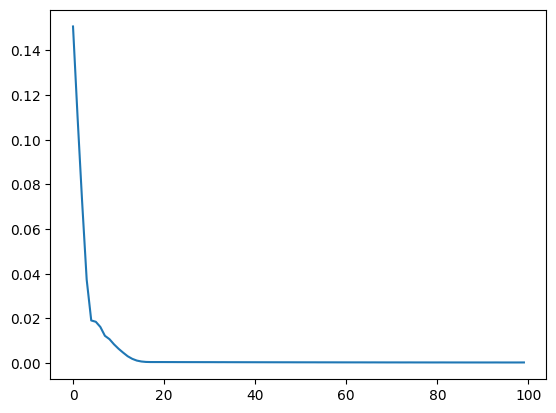

In [78]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
     

In [79]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform([y_train])
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform([y_test])
train_score = np.sqrt(np.mean(np.square(y_train - train_predictions)))
test_score = np.sqrt(np.mean(np.square(y_test - test_predictions)))
print('Train Score: %.2f RMSE' % (train_score))
print('Test Score: %.2f RMSE' % (test_score))


4/4 [==============================] - 0s 2ms/step
Train Score: 24.24 RMSE
Test Score: 9.05 RMSE


In [80]:
print('Train Score: %.2f RMSE' % (train_score))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 24.24 RMSE
Test Score: 9.05 RMSE


In [81]:
mse = np.mean(np.square(y_test - test_predictions))
mse

81.94610079165477

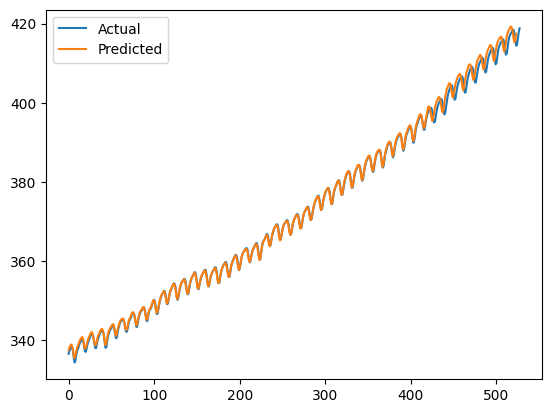

In [82]:
import matplotlib.pyplot as plt
plt.plot(df['average'].values, label='Actual')
plt.plot(np.concatenate([train_predictions, test_predictions]), label='Predicted')
plt.legend()
plt.show()

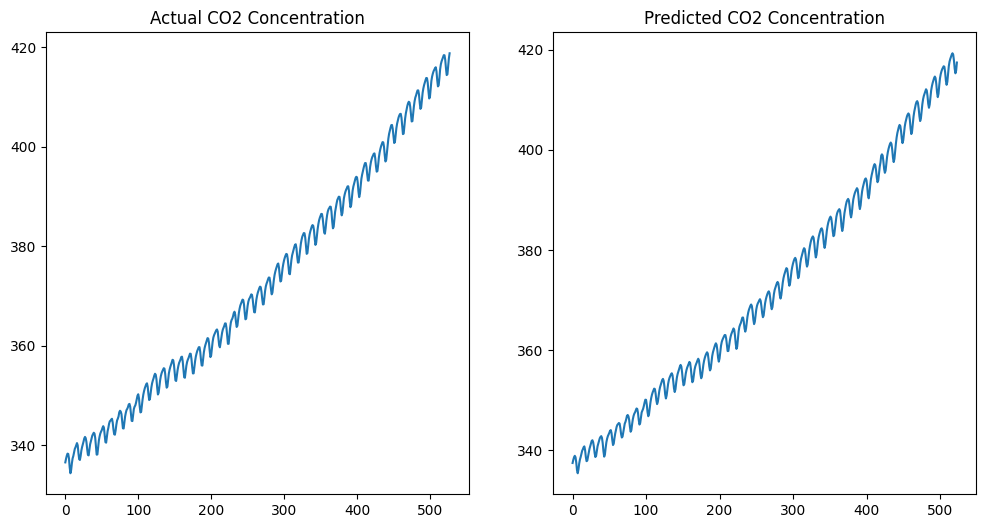

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(df['average'].values)
ax1.set_title('Actual CO2 Concentration')

ax2.plot(np.concatenate([train_predictions, test_predictions]))
ax2.set_title('Predicted CO2 Concentration')

plt.show()


In [84]:
# time_steps = 12
last_time_steps = data[-time_steps:]
future_predictions = []
for i in range(24): # predict the next 24 months
    next_prediction = model.predict(last_time_steps.reshape(1, time_steps, 1))
    future_predictions.append(next_prediction[0,0])
    last_time_steps = np.concatenate([last_time_steps[1:], next_prediction], axis=0)


1/1 [==============================] - 0s 18ms/step


In [85]:
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))

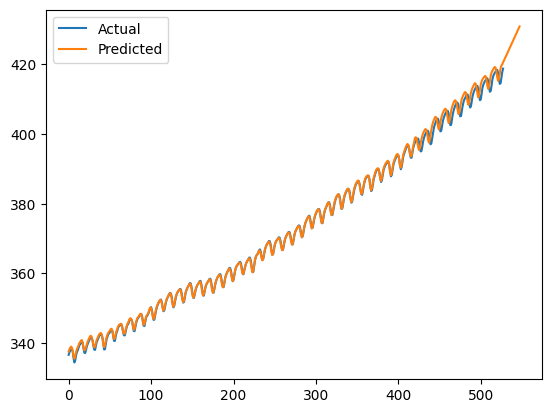

In [86]:
plt.plot(df['average'].values, label='Actual')
plt.plot(np.concatenate([train_predictions, test_predictions, future_predictions]), label='Predicted')
plt.legend()
plt.show()